<a href="https://colab.research.google.com/github/Passssa/lolkek/blob/main/lab2/Lab2_3var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   
`Выполнил Вишневецкий Денис (3 вариант)` 


# Лабораторная работа №3: Линейные модели. Кросс-валидация. 


*Модели*: множественная линейная регрессия 

*Данные*: `insurance` (источник: <https://www.kaggle.com/mirichoi0218/insurance/version/1>)

In [ ]:
# Загружаем нужные пакеты:

# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

# константы
#  ядро для генератора случайных чисел
my_seed = 9212
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

### Далее загрузим наши данные для работы

Набор данных `insurance` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/insurance.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [ ]:
# читаем таблицу расширения .csv во фрейм
DF_raw = pd.read_csv('https://raw.githubusercontent.com/ania607/ML/main/data/Boston_for_lab.csv')

# выясняем размерность фрейма
DF_raw.shape

(506, 15)

In [ ]:
# выводим первые несколько строк таблицы
DF_raw.head(5)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,tax_over_400
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0


In [ ]:
DF_raw.dtypes #типы заначений в столбцах

crim            float64
zn              float64
indus           float64
chas              int64
nox             float64
rm              float64
age             float64
dis             float64
rad               int64
tax               int64
ptratio         float64
black           float64
lstat           float64
medv            float64
tax_over_400      int64
dtype: object

In [ ]:
# Проверим нашу модель на качество
print(DF_raw.isnull().sum()+DF_raw.isna().sum())
DF_raw.info()

crim            0
zn              0
indus           0
chas            0
nox             0
rm              0
age             0
dis             0
rad             0
tax             0
ptratio         0
black           0
lstat           0
medv            0
tax_over_400    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   crim          506 non-null    float64
 1   zn            506 non-null    float64
 2   indus         506 non-null    float64
 3   chas          506 non-null    int64  
 4   nox           506 non-null    float64
 5   rm            506 non-null    float64
 6   age           506 non-null    float64
 7   dis           506 non-null    float64
 8   rad           506 non-null    int64  
 9   tax           506 non-null    int64  
 10  ptratio       506 non-null    float64
 11  black         506 non-null    float64
 12  lstat

Отсутствуют пустые(или нулевые по значению) ячейки и количество наблюдений по столбцам одинаковое. Данные в таблице пригодны для анализа.

### Задание 1. Делим наш фрейм на обучение и тесты. 
Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели. Также согласно варианту 3, оставляет только нужные столбцы

In [ ]:
DF_raw = DF_raw[['rm', 'dis', 'medv', 'tax_over_400']]
DF_raw.head()

,rm,dis,medv,tax_over_400
0,6.575,4.0900,24.0,0
1,6.421,4.9671,21.6,0
2,7.185,4.9671,34.7,0
3,6.998,6.0622,33.4,0
4,7.147,6.0622,36.2,0


In [ ]:
# данные для построения моделей
DF = DF_raw.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_raw.drop(DF.index)

In [ ]:
DF.head(10)

,rm,dis,medv,tax_over_400
105,5.851,2.1069,19.5,0
26,5.813,4.6820,16.6,0
180,7.765,2.7410,39.8,0
46,5.786,5.1004,20.0,0
76,6.279,4.0522,20.0,0
260,7.203,2.1121,33.8,0
8,5.631,6.0821,16.5,0
481,6.750,3.3317,23.7,1
56,6.383,9.1876,24.7,0
30,5.713,4.2330,12.7,0


In [ ]:
DF_predict.head(10)

,rm,dis,medv,tax_over_400
1,6.421,4.9671,21.6,0
3,6.998,6.0622,33.4,0
4,7.147,6.0622,36.2,0
5,6.430,6.0622,28.7,0
6,6.012,5.5605,22.9,0
31,6.072,4.1750,14.5,0
43,6.211,5.7209,24.7,0
51,6.115,6.8147,20.5,0
55,7.249,8.6966,35.4,0
61,5.966,6.8185,16.0,0


Здесь:
* **rm**- среднее количество комнат в доме;;
* **dis**– средневзвешенное расстояние до пяти бостонских центров занятости;
* **medv**– медианная стоимость домов, занимаемых владельцами, в тысячах долларов;
* **tax_over_400**– фиктивная переменная: 1 если полная ставка налога на имущество \ на 10000 долларов превышает 400.

In [ ]:
# удаляем фрейм-исходник
del DF_raw

## Задание 2.Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что все переменные сильно отличаются по масштабу.

In [ ]:
# описательные статистики для непрерывных переменных
DF[['medv', 'rm', 'dis']].describe()

,medv,rm,dis
count,405.000000,405.000000,405.000000
mean,22.506173,6.264746,3.752900
std,9.192299,0.712511,2.021602
min,5.000000,3.561000,1.129600
25%,17.200000,5.875000,2.086900
50%,21.000000,6.167000,3.215700
75%,25.000000,6.606000,5.100400
max,50.000000,8.780000,10.710300


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

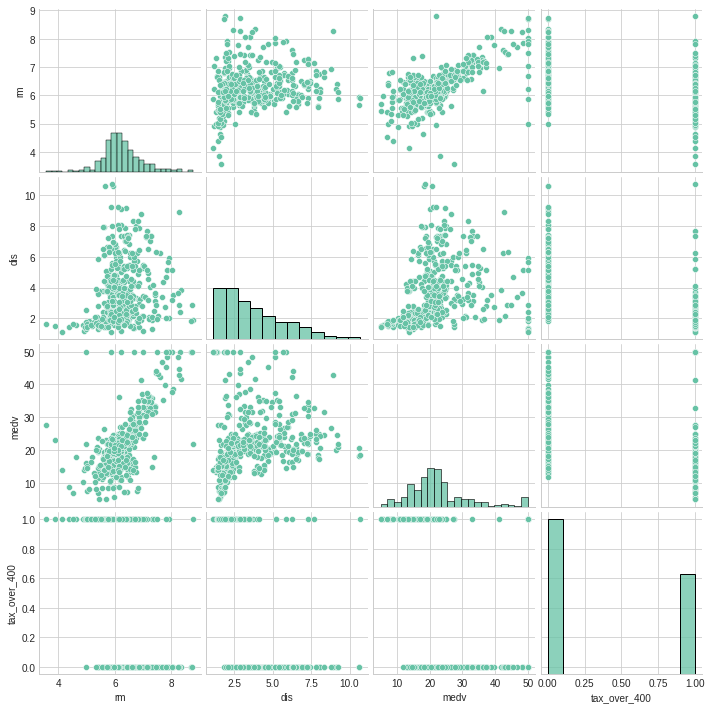

In [ ]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['rm', 'dis', 'medv', 'tax_over_400']])
plt.show()

Судя по этим графикам:

- tax_over_400 дискретна, остальные непрерывны;

- распределение зависимой medv не является нормальным;

- из всех объясняющих нормально распределена только rm;

- прослеживается линейная связь у medv и rm, но есть сильно отклоняющиеся точки. 
Скорее всего, связь будет умеренной.

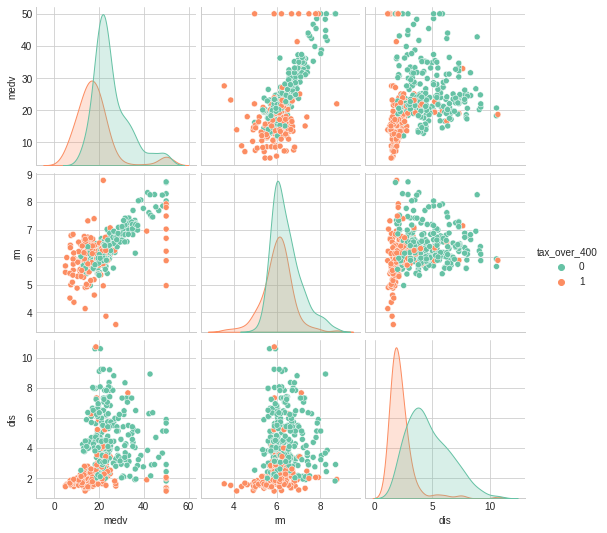

In [ ]:
sns.pairplot(DF[['medv', 'rm', 'dis', 'tax_over_400']],
            hue='tax_over_400')

plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма.

In [ ]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


,medv,rm,dis
medv,1.00,0.68,0.21
rm,0.68,1.00,0.18
dis,0.21,0.18,1.00


Посчитаем корреляционные матрицы для тех, чья полная ставка налога на имущество \ на $10000 превышает 400 (фиктивная переменная = 1)

In [ ]:
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,medv,rm,dis
medv,1.00,0.33,0.10
rm,0.33,1.00,0.19
dis,0.10,0.19,1.00


Посчитаем корреляционные матрицы для тех, чья полная ставка налога на имущество \ на $10000 не превышает 400 (фиктивная переменная = 0)

In [ ]:
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,medv,rm,dis
medv,1.00,0.90,-0.09
rm,0.90,1.00,-0.05
dis,-0.09,-0.05,1.00


Вывод: стоимость домов сильно зависит от количества комнат в доме, если полная ставка налога на имущество \ на $10000 не превышает 400. Если привышает, корреляция почти в два раза меньше.



### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [ ]:
# логарифмируем зависимую переменную
DF['log_medv'] = np.log(DF['medv'])


Проведём формальные тесты на нормальность.

In [ ]:
# тестируем на нормальность
for col in ['medv', 'log_medv']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

medv Statistics=0.91, p=0.0000
Распределение не нормально (H0 отклоняется)

log_medv Statistics=0.97, p=0.0000
Распределение не нормально (H0 отклоняется)



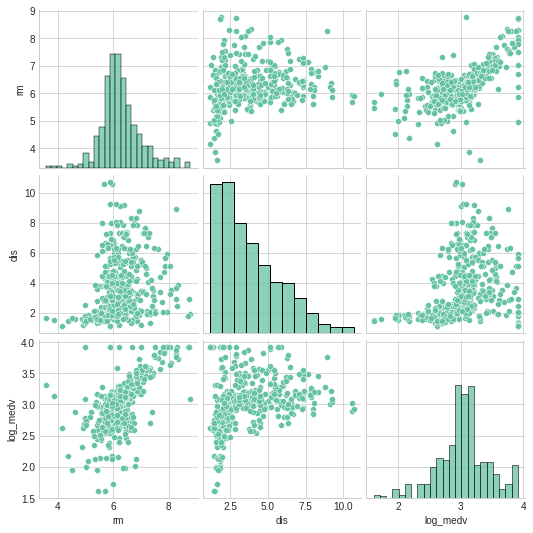

In [ ]:
sns.pairplot(DF[['rm', 'dis', 'log_medv']])
plt.show()

Логарифмирование меняет взаимосвязи между переменными.

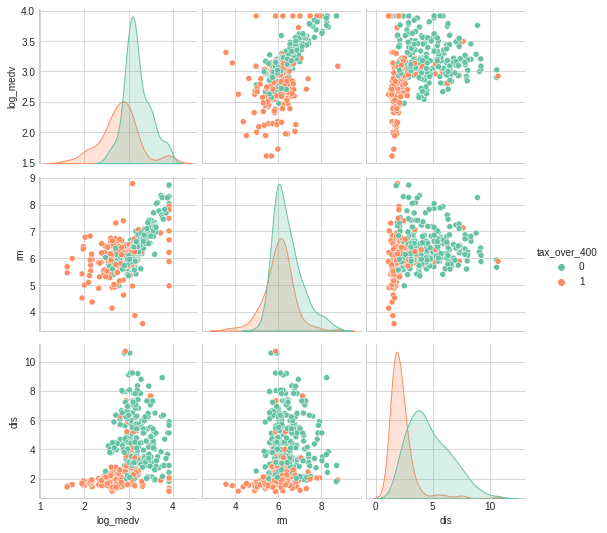

In [ ]:
sns.pairplot(DF[['log_medv', 'rm', 'dis', 'tax_over_400']], hue='tax_over_400')
plt.show()

In [ ]:
corr_mat = DF[['medv', 'log_medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,medv,log_medv,rm,dis
medv,1.00,0.95,0.68,0.21
log_medv,0.95,1.00,0.62,0.30
rm,0.68,0.62,1.00,0.18
dis,0.21,0.30,0.18,1.00


Связь между объясняющей переменной rm и прологарифмированной зависимой log_medv стала слабее.

In [ ]:
corr_mat = DF.loc[DF['tax_over_400'] == 1][['medv', 'log_medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,medv,log_medv,rm,dis
medv,1.00,0.93,0.33,0.10
log_medv,0.93,1.00,0.32,0.20
rm,0.33,0.32,1.00,0.19
dis,0.10,0.20,0.19,1.00


In [ ]:
corr_mat = DF.loc[DF['tax_over_400'] == 0][['medv', 'log_medv', 'rm', 'dis']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,medv,log_medv,rm,dis
medv,1.00,0.98,0.90,-0.09
log_medv,0.98,1.00,0.87,-0.07
rm,0.90,0.87,1.00,-0.05
dis,-0.09,-0.07,-0.05,1.00



Также произошло и для дискретной объясняющей переменной tax_over_400. Это значит, что ошибка модели на обучающей выборке с прологарифмированной зависимой переменной будет немного больше, чем с изначальной. Let's check it.

## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax_over_400 + \hat{\beta_2} \cdot rm + \hat{\beta_3} \cdot dis$
1. `fit_lm_2`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax_over_400 + \hat{\beta_2} \cdot rm \cdot tax_over_400 + \hat{\beta_3} \cdot dis$
1. `fit_lm_3`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax_over_400 + \hat{\beta_2} \cdot dis \cdot tax_over_400 + \hat{\beta_3} \cdot rm$
1. `fit_lm_4`: $\hat{medv} = \hat{\beta_0} + \hat{\beta_1} \cdot tax_over_400 + \hat{\beta_2} \cdot dis \cdot tax_over_400 + \hat{\beta_3} \cdot rm \cdot tax_over_400$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_medv}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_medv}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_medv}$

Кроме того, добавим в сравнение модели зависимости `medv` и `log_medv` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно.  


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [ ]:
# данные для моделей 1, 5
df1 = DF[['medv', 'tax_over_400', 'rm', 'dis']]

# данные для моделей 2, 6
df2 = DF[['medv', 'tax_over_400', 'rm', 'dis']]
df2.loc[:, 'rm_tax_over_400'] = df2.loc[:, 'rm'] * df2.loc[:, 'tax_over_400']
df2 = df2.drop(['rm'], axis=1)

# данные для моделей 3, 7
df3 = DF[['medv', 'tax_over_400', 'rm', 'dis']]
df3.loc[:, 'dis_tax_over_400'] = df3.loc[:, 'dis'] * df3.loc[:, 'tax_over_400']
df3 = df3.drop(['dis'], axis=1)

# данные для моделей 4, 8
df4 = DF[['medv', 'tax_over_400', 'rm', 'dis']]
df4.loc[:, 'rm_tax_over_400'] = df4.loc[:, 'rm'] * df4.loc[:, 'tax_over_400']
df4.loc[:, 'dis_tax_over_400'] = df4.loc[:, 'dis'] * df4.loc[:, 'tax_over_400']
df4 = df4.drop(['rm', 'dis'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_medv'], axis=1)

In [ ]:
# проверка результатов
df0.head(5)

,rm,dis,medv,tax_over_400
105,5.851,2.1069,19.5,0
26,5.813,4.6820,16.6,0
180,7.765,2.7410,39.8,0
46,5.786,5.1004,20.0,0
76,6.279,4.0522,20.0,0


Построим модели от всех объясняющих переменных на всех наблюдениях DF, чтобы проинтерпретировать параметры. В модели для зависимой переменной medv интерпретация стандартная:

Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.
Коэффициент при объясняющей переменной  показывает, на сколько своих единиц измерения изменится , если  увеличится на одну свою единицу измерения.

In [ ]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [-25.671] 
 объясняющие  ['rm', 'dis', 'tax_over_400'] 
 коэффициенты  [[ 8.087 -0.199 -4.421]]


In [ ]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([6.42665934])

С интерпретацией модели на логарифме  дела обстоят сложнее:

Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.
Коэффициент при  нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если  увеличится на одну свою единицу измерения.

In [ ]:
# модель со всеми объясняющими, y_log
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [1.213] 
 объясняющие  ['rm', 'dis', 'tax_over_400'] 
 коэффициенты  [[ 0.304  0.005 -0.255]]


In [ ]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ 35.5,   0.5, -22.5]])

In [ ]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([6.15327605])

In [ ]:
print('MSE_train модели для medv меньше MSE_train',
     'модели для log(medv) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для medv меньше MSE_train модели для log(medv) в  [0.9] раз


Действительно. Так произошло, потому что корреляция стала меньше для объясняющих переменных и прологарифмированной зависимой.

### Оценка точности


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.  

In [ ]:
# Перекрёстная проверка по 10 блокам
folds = 5

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 5)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = df.medv
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.15 секунд


In [ ]:
# Перекрёстная проверка по 10 блокам
folds = 5

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 5)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['medv'], axis=1)
    y = np.log(df.medv)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.14 секунд


In [ ]:
scores

[-42.049847399187676,
 -42.267278254405966,
 -70.15555932930565,
 -42.61097155757153,
 -69.08134287469854]

In [ ]:
[np.around(-x, 2) for x in scores]

[42.05, 42.27, 70.16, 42.61, 69.08]

In [ ]:
# самая точная на medv
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf5 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf5 = 42.0


In [ ]:
[np.around(-x, 5) for x in scores_log]

[0.08499, 0.08629, 0.12291, 0.08599, 0.12035]

In [ ]:
# самая точная на log(medv)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf5 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0_log :
MSE_kf5 = 0.085


Самой точной среди моделей для medv оказалась fit_lm_0, а среди моделей для medv_log – fit_lm_0_log. Оценим точность прогноза по этим моделям на отложенные наблюдения.

In [ ]:
# прогноз по fit_lm_0
#  модель на всех обучающих наблюдениях
X = df0.drop(['medv'], axis=1)
y = df0.medv.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['medv']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_0 на отложенных наблюдениях = 32.66


In [ ]:
y_pred[:10]

array([[25.26365832],
       [29.71150953],
       [30.91642588],
       [25.11827136],
       [21.83798551],
       [22.59920771],
       [23.41528112],
       [22.42105102],
       [31.21643959],
       [21.21537763]])

In [ ]:
# прогноз по fit_lm_log_0
# модель
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['medv']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 27.68


In [ ]:
y_pred[:10]

array([[3.18837712],
       [3.36928631],
       [3.41452732],
       [3.19682395],
       [3.06728839],
       [3.07827681],
       [3.1285479 ],
       [3.10510669],
       [3.45924377],
       [3.05988551]])

In [ ]:
np.around(np.sqrt(MSE) / np.mean(DF_predict[['medv']]) * 100, 1)

medv    25.2
dtype: float64

In [ ]:
np.around(np.sqrt(MSE_log) / np.mean(DF_predict[['medv']]) * 100, 1)

medv    23.2
dtype: float64

Очевидно, на выборке для прогноза точнее модель fit_lm_0_log: она содержит все объясняющие переменные.

In [ ]:
X = df0.drop(['medv'], axis=1)
y = np.log(df0.medv).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['medv']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['medv'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(df0.drop(['medv'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [1.213] 
 объясняющие  ['rm', 'dis', 'tax_over_400'] 
 коэффициенты  [[ 0.304  0.005 -0.255]]


Для интерпретации параметров прологарифмированной модели необходимо их экспоненциировать.

In [ ]:
const_exp = np.exp(fit_lm_0_log.intercept_)
coef_exp = np.exp(fit_lm_0_log.coef_)
coef_exp_final = [(x-1)*100 for x in coef_exp]
print('Константа:', float(np.around(const_exp, 3)))

Константа: 3.363


In [ ]:
print('Объясняющие:', list(df0.drop(['medv'], axis=1).columns.values),
      '\nКоэффициенты:', (np.around(coef_exp_final, 3)))

Объясняющие: ['rm', 'dis', 'tax_over_400'] 
Коэффициенты: [[ 35.477   0.523 -22.518]]


### Интерпретация параметров модели
Y = 3.167 + 36.548rm + 0.804dis - 23.255tax_over_400

Ошибка модели на отложенных наблюдениях составила 27.1% от среднего значения Y
Если объясняющие переменные будут равняться нулю, то Y равен константе = 3.167.
При увеличении rm на единицу, Y увеличится на 36.548. При увеличении dis на единицу, Y увеличится на 0.804. При значении дискретной переменной tax_over_400 = 1, Y уменьшается на 23.255, а при значении равном нулю, значение Y зависит только от непрерывных переменных.
Проверим нашу модель на выборке.

In [ ]:
y_pred = fit_lm_0_log.predict(X[:10])
np.exp(y_pred)

array([[24.24904222],
       [29.05778141],
       [30.40257526],
       [24.45473717],
       [21.48356855],
       [21.72094086],
       [22.84078828],
       [22.31159935],
       [31.79292461],
       [21.3251156 ]])

In [ ]:
DF_predict.head(10)

,rm,dis,medv,tax_over_400
1,6.421,4.9671,21.6,0
3,6.998,6.0622,33.4,0
4,7.147,6.0622,36.2,0
5,6.430,6.0622,28.7,0
6,6.012,5.5605,22.9,0
31,6.072,4.1750,14.5,0
43,6.211,5.7209,24.7,0
51,6.115,6.8147,20.5,0
55,7.249,8.6966,35.4,0
61,5.966,6.8185,16.0,0


Можно заметить, что значения Y в отложенной выборке и предсказанные моделью значения довольно схожи.

# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  